In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '..')
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import integrated_gradients
import seaborn as sns
import fiona
import geopandas as gpd

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [2]:
## Define some general arguments for the notebook
mod = 'RGCN'  #GWN or RGCN
base = 'zeros' #zeros or mean
grad_steps = 50 #Number of steps to take in calculation of IG
year_index = -1 #Sequence to apply IG to
weights_file = f'../../river-dl/results/baseline/{mod}/rep_5/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/{mod}/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 90
num_rand = 30 #number of random sequences to average some chunks


river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_tst'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]
segs = gpd.read_file('../../river-dl/data_DRB/DRB_spatial/segs/segs.shp')
seg_ids = river_dl['ids_tst'][-455:][:,0,:].flatten()
x_vars = river_dl['x_vars']
num_vars = len(x_vars)

if base == 'zeros':
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[455*year_index:]
    baseline = torch.zeros_like(x)

elif base == 'mean':
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()
    n_series = river_dl['x_tst'].shape[0]
    baseline = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)
    baseline = torch.mean(baseline,dim=0)
    x = x[455*year_index:]

dates_x = river_dl['times_tst'][455*year_index:][0].flatten()

x.shape,baseline.shape, adj_matrix.shape, device

(torch.Size([455, 180, 7]),
 torch.Size([455, 180, 7]),
 (455, 455),
 device(type='cuda', index=0))

In [3]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix,device=device)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)

model.eval()
model.to(device)

RGCN_v1(
  (dropout): Dropout(p=0, inplace=False)
  (recur_dropout): Dropout(p=0, inplace=False)
  (dense): Linear(in_features=20, out_features=1, bias=True)
)

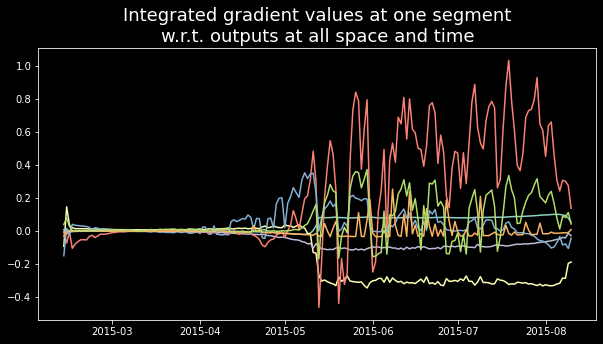

In [4]:
IG_vals = integrated_gradients(x, model, grad_steps, baseline, temporal_focus=range(pred_length,seq_len))
plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

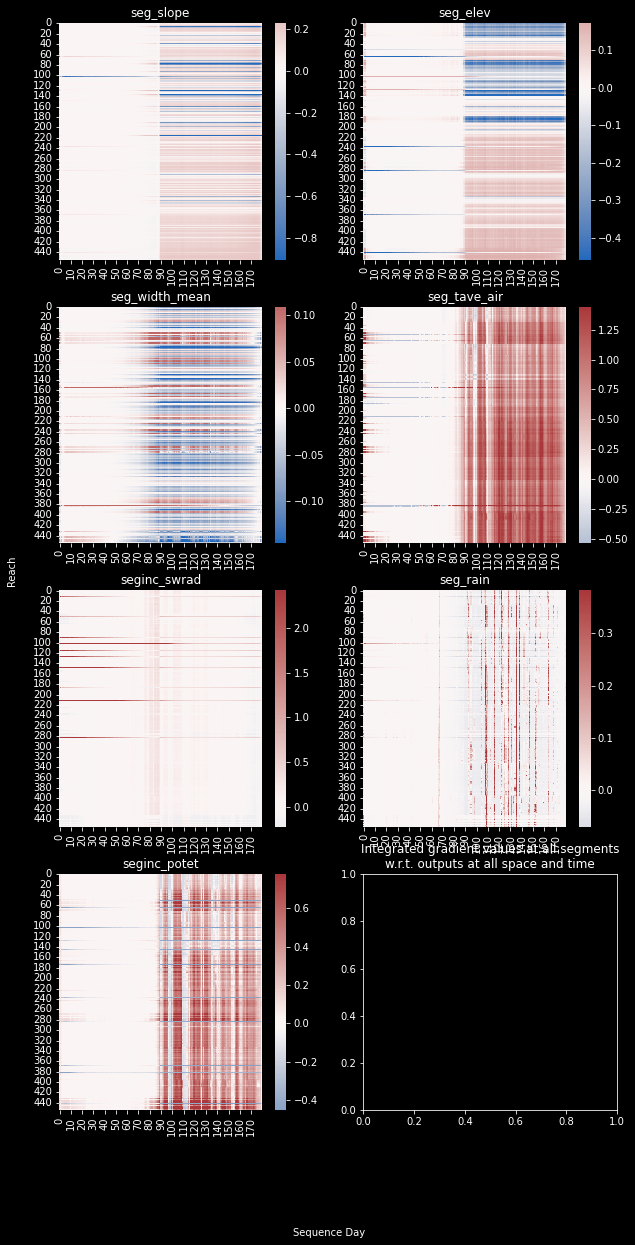

In [5]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(num_vars):
    IG = IG_vals[:,:,i]
    low_lim = np.quantile(IG,.01)
    high_lim = np.quantile(IG,.99)
    sns.heatmap(IG,vmin=low_lim,vmax=high_lim,center=0, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(x_vars[i])

fig.text(0.5, 0.04, 'Sequence Day', ha='center', va='center')
fig.text(0.06, 0.5, 'Reach', ha='center', va='center', rotation='vertical')
plt.tight_layout
plt.title('Integrated gradient values at all segments\nw.r.t. outputs at all space and time')
plt.show()

## lets try to make a seg to seg heatmap

In [6]:
seg2seg_influence = []
for i in range(455):
    IG_vals = integrated_gradients(x, model, grad_steps,baseline, spatial_focus=i, temporal_focus=range(pred_length,seq_len))
    reduced = np.mean(IG_vals,axis=1)
    seg2seg_influence.append(reduced)

seg2seg_influence=np.asarray(seg2seg_influence)

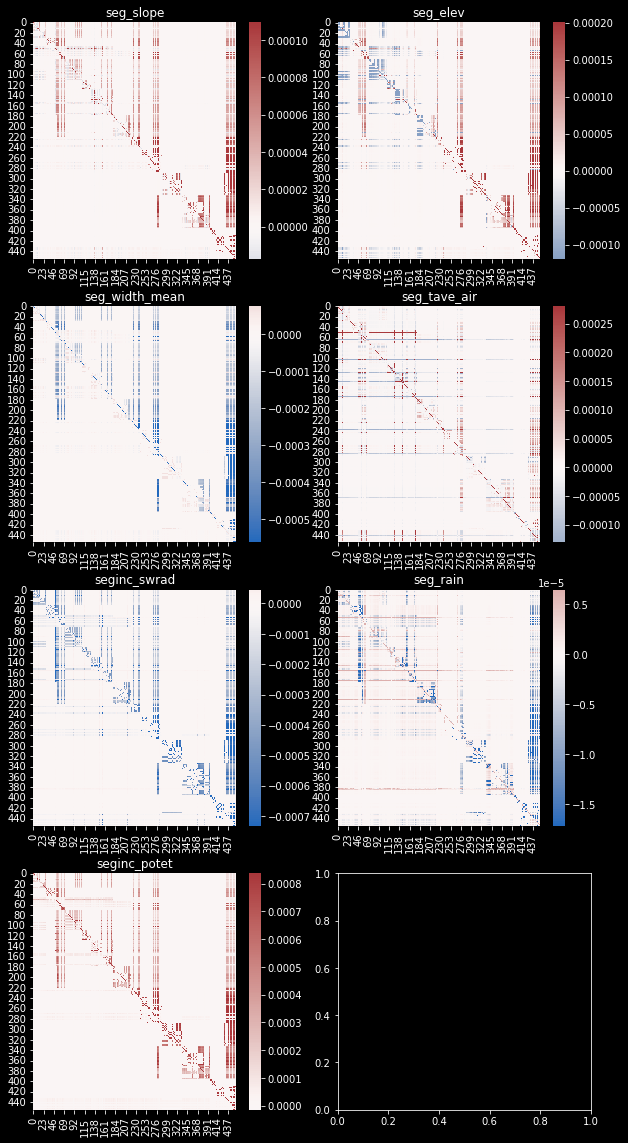

In [7]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))

for i in range(num_vars):
    IG = seg2seg_influence[:,:,i]
    low_lim = np.quantile(IG,.01)
    high_lim = np.quantile(IG,.99)
    sns.heatmap(IG, vmin=low_lim,vmax=high_lim, center=0,cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(x_vars[i])

plt.tight_layout
plt.show()


## Pretty hard to interpret, lets try an experiment where we noise everything but the target reach

In [8]:
def noise_segs(seg_of_interest):
    with torch.no_grad():
        y_hat_original = model(x)#[:,90:180,:]
    x_hypothesis = torch.rand_like(x)
    x_hypothesis[seg_of_interest] = x[seg_of_interest]
    with torch.no_grad():
        y_hat_hypothesis = model(x_hypothesis)#[:,90:180,:]
    y_diff = y_hat_original[seg_of_interest, :].detach().cpu() - y_hat_hypothesis[seg_of_interest, :].detach().cpu()
    y_diff = np.mean(y_diff.numpy())
    return y_diff

In [9]:
batches = river_dl['x_tst'].shape[0]/n_segs
rand_batch = np.random.randint(0,batches,num_rand)
batches, rand_batch

(38.0,
 array([ 2, 28, 34, 17, 19, 22, 33, 32,  9, 32, 32, 25, 19, 14, 36, 32, 16,
         4,  3,  2, 20,  2, 20,  7, 35, 28, 33, 21, 30, 27]))

In [10]:
diffs =[]
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind] 
    for j in range(n_segs):
        d = noise_segs(j)
        diffs.append(d)

diffs = np.asarray(diffs).reshape(num_rand,n_segs).mean(axis=0)
diffs = diffs*river_dl['y_std'][0]
diffs_sf = pd.DataFrame({'sg_d_nt':seg_ids, 'diffs':np.abs(diffs)}).merge(segs).set_geometry('geometry')
diffs.shape

(455,)

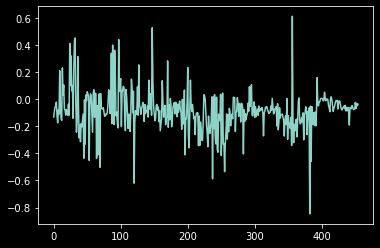

In [11]:
plt.plot(diffs)

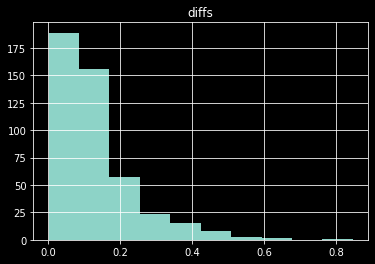

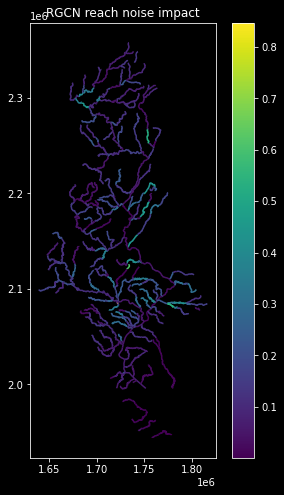

In [12]:
diffs_sf.hist('diffs')
fig, ax = plt.subplots(figsize = (6,8))
diffs_sf.plot(column='diffs', ax = ax, legend = True)
plt.title(f"{mod} reach noise impact")
plt.savefig(f'../figures/{mod}_30_reach_noise.png',bbox_inches='tight')

## Lets do a similar exercice, but use IGs to look at specific reaches of interest

1638-Contains Neversink; 1639 downstream

1560,1562-Contains Cannonsville; 1566 downstream 

1449-Contains Popocton, 1450 downstream

Random mainstem downstream 1780, 1817 

In [13]:
reach = np.where(seg_ids == 1566)[0][0]

In [15]:
batches = river_dl['x_tst'].shape[0]/n_segs
rand_batch = np.random.randint(0,batches,num_rand)

igs = []
for i in rand_batch:
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
    IG_vals = integrated_gradients(x, model, grad_steps, baseline, spatial_focus=reach,temporal_focus=range(pred_length,seq_len))
    IG_vals[reach,:,:] = np.nan
    reduced = np.mean(np.abs(IG_vals),axis=1)
    igs.append(reduced)
igs = np.asarray(igs).mean(axis=0)

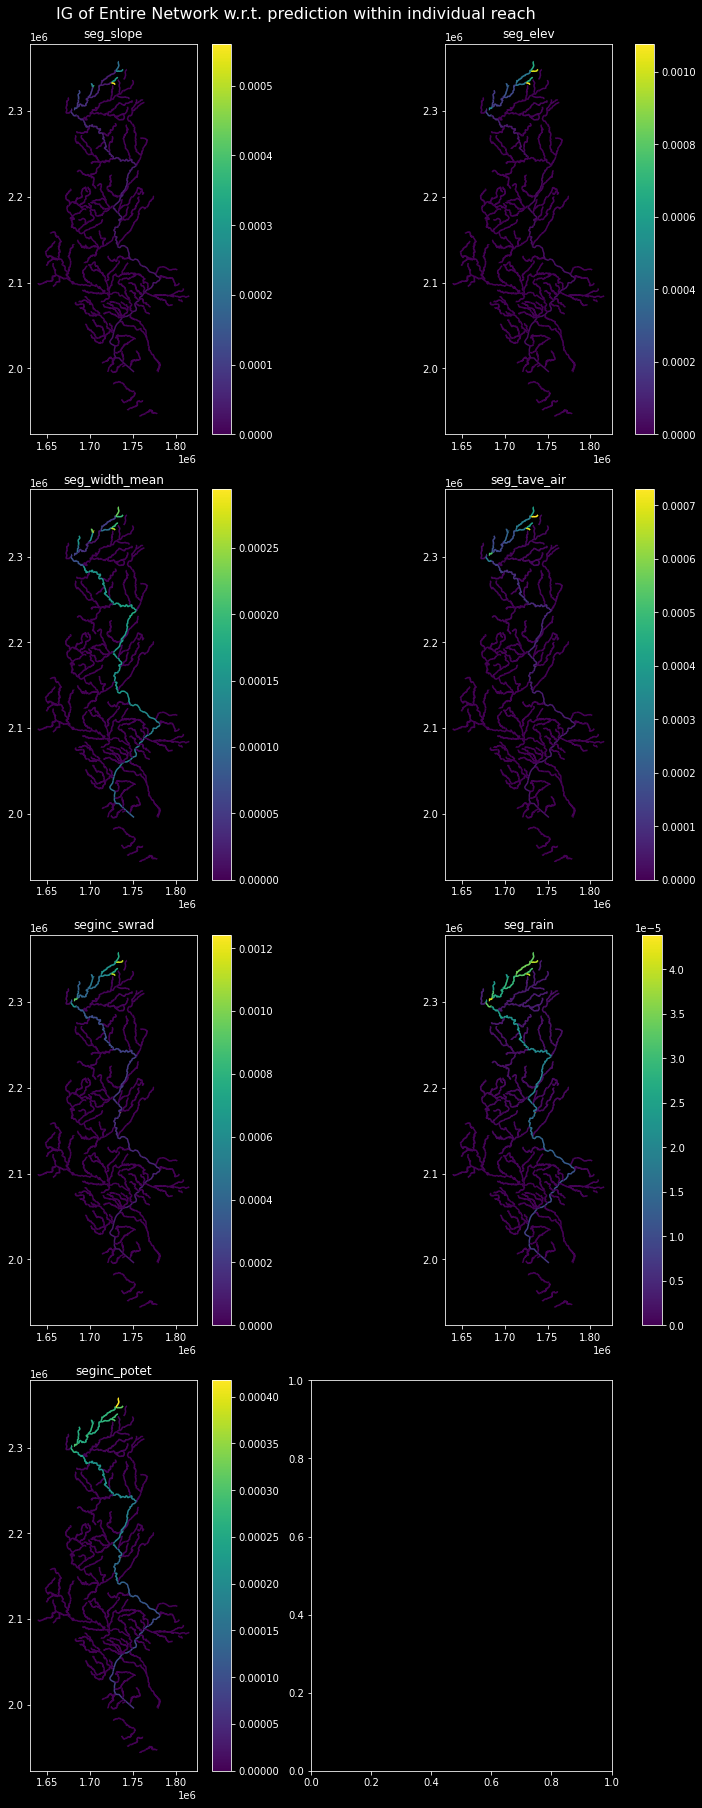

In [16]:
#igs_sf = pd.DataFrame({'sg_d_nt':ids[:len(diffs)], 'igs':reduced}).merge(segs).set_geometry('geometry')
igs_sf = pd.DataFrame(columns=river_dl['x_vars'],data=igs)
igs_sf['sg_d_nt']=seg_ids
igs_sf = igs_sf.merge(segs).set_geometry('geometry')
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(11.2,25),constrained_layout=True)
fig.suptitle('IG of Entire Network w.r.t. prediction within individual reach',fontsize=16)
for i in range(num_vars):
    igs_sf.plot(column=river_dl['x_vars'][i],ax = axes.reshape(-1)[i],legend=True)
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i]) 

## Lets do some time traveling

In [17]:
#df = pd.DataFrame(columns=['date','ig_val'])
igs = []
dates = []
for i in range(1,20):
    start_ind = n_segs*i-n_segs
    end_ind = n_segs*i
    x = torch.from_numpy(river_dl['x_tst']).to(device).float()[start_ind:end_ind]
    dates_x = river_dl['times_tst'][start_ind:end_ind][0].flatten()
    IG_vals = integrated_gradients(x, model, grad_steps, baseline, temporal_focus=-1)
    ig_temp_mean = np.mean(IG_vals, axis=0)
    igs.append(ig_temp_mean)
    dates.append(dates_x)

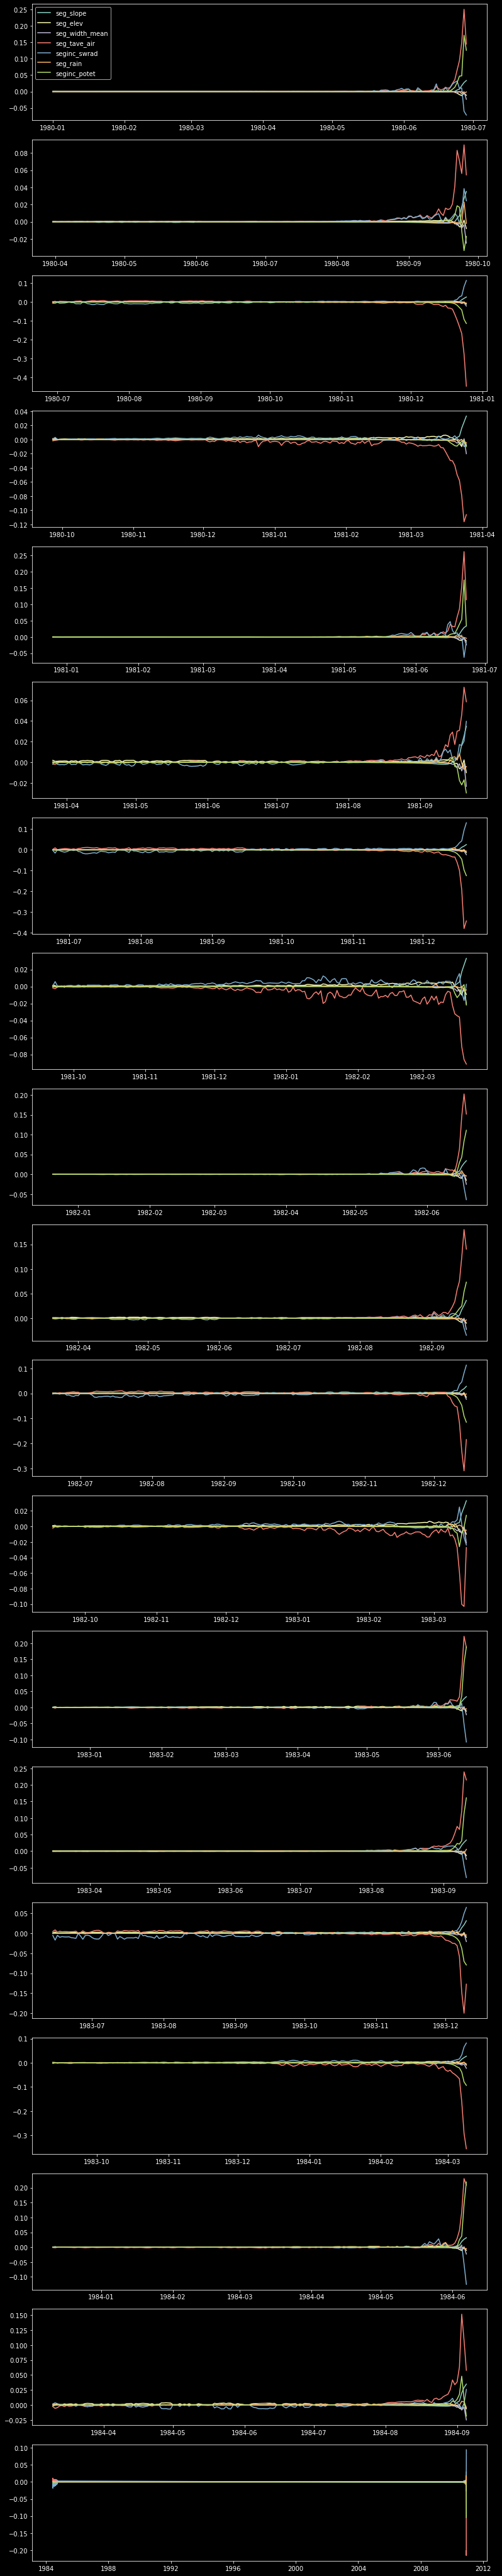

In [18]:
#igs=np.assarray(igs)
num_plots = len(dates)
fig, axes = plt.subplots(nrows=num_plots,figsize=(11.2,3*num_plots), tight_layout=True)
for j in range(num_plots):
    for i in range(num_vars):
        axes[j].plot(dates[j],igs[j][:, i], label = river_dl['x_vars'][i])
    if j == 0:
        axes[j].legend(loc = 'upper left')